In [69]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy

In [70]:
env_cp = gym.make('CartPole-v0')

In [3]:
env_cp.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [4]:
env_cp.reset()

array([-0.00237192,  0.04122553,  0.00393938, -0.00313801], dtype=float32)

In [5]:
env_cp.render()

True

In [6]:
env_cp.close()

In [7]:
env_cp.action_space

Discrete(2)

In [71]:
def episode(env, agent, epsilon):
    state = env.reset()
    done = False
    gain = 0
    while not done:
        action = agent.epsilon_greedy_action(state, epsilon )
        state, reward, done, info = env.step(action)
        gain += reward
        #env.render()
        #print(state, reward, done, info)
    return gain


## Approximation linéaire en numpy

NB : il arrive que le q-learning converge sans le target network mais la convergence est globalement meilleure avec, expérimentalement dans ce cas avec une mise à jour tous les 10 épisodes

In [23]:
class Agent_approx_lineaire:
    def __init__(self):
        self.W = np.zeros((2,4))
        self.W_fixe = np.array(self.W)
        
        
    def forward(self, etat, action):
        """renvoie q*(etat, action) estimé
        """
        #sa = np.concatenate((np.array([1]), etat))
        sa = etat
        return self.W_fixe.dot(sa)[action]
        
    
    def backward(self, etat, action, target, alpha):
        """ pas de gradient pour rapprocher
        q*(etat,action) de la valeur target
        """
        #sa = np.concatenate((np.array([1]), etat))
        sa = etat
        f = self.forward(etat, action)
        
        # pas de gradient
        self.W[action] -= alpha*(f - target)*sa
        
        
    def epsilon_greedy_action(self, etat, epsilon):
        if random.random() < epsilon:
            return random.randint(0,1)
        else:
            if self.forward(etat, 0) >= self.forward(etat, 1):
                return 0
            else:
                return 1
        
        

In [29]:
def qlearning(env, agent, nb_episode, alpha, epsilon, gamma):
    logs = []
    
    for t in range(nb_episode):
        state = env.reset()
        done = False
        gain = 0
        while not done:
            action = agent.epsilon_greedy_action(state, epsilon)
            new_state, reward, done, info = env.step(action)
            
            #mise a jour du qlearning
            
            maxi = max(agent.forward(new_state,0),agent.forward(new_state,1))
            target = reward + gamma*maxi
            agent.backward(state, action, target, alpha)
            
            gain += reward
            state = new_state
            
        
        if t %10 == 0: #meilleur après expérimentation
           agent.W_fixe = np.array(agent.W)
           #env.render()
           #print(state, reward, done, info)
        logs.append(gain)
    return logs

In [30]:
def interval_average_list(tab, k):
    return [sum(tab[i:i+k])/k for i in range(len(tab)-k)]

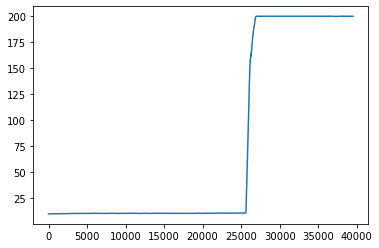

In [31]:
agent = Agent_approx_lineaire()
logs = qlearning(env_cp, agent, 40000, alpha=0.01, epsilon =0.1, gamma=0.8)
plt.plot(interval_average_list(logs,500))